In [1]:
import pytest
from astropy import units as u
import numpy as np
from numpy.testing import assert_almost_equal, assert_array_equal
from scipy.signal import unit_impulse as deltafn
import lightkurve as lk
from lightkurve.periodogram import SNRPeriodogram

In [2]:
def generate_test_spectrum():
    """Generates a simple solar-like oscillator spectrum of oscillation modes
    """
    f = np.arange(0, 4000., 0.4)
    p = np.ones(len(f))
    nmx = 2500.
    fs = f.max()/len(f)

    s = 0.25*nmx/2.335    #std of the hump
    p *= 10 * np.exp(-0.5*(f-nmx)**2/s**2)  #gaussian profile of the hump

    m = np.zeros(len(f))
    lo = int(np.floor(.5*nmx/fs))
    hi = int(np.floor(1.5*nmx/fs))

    dnu_true = 0.294 * nmx ** 0.772
    modelocs = np.arange(lo, hi, dnu_true/2, dtype=int)

    for modeloc in modelocs:
        m += deltafn(len(f), modeloc)
    p *= m
    p += 1
    return f, p, nmx, dnu_true


test estimate numax

In [3]:
"""Test if we can estimate a numax
"""
f, p, true_numax, _ = generate_test_spectrum()
snr = SNRPeriodogram(f*u.microhertz, u.Quantity(p, None))
numax = snr.estimate_numax()

#Assert recovers numax within 10%
assert(np.isclose(true_numax, numax.value, atol=.1*true_numax))
#Assert numax has unit equal to input frequency unit
assert(numax.unit == u.microhertz)
#Assert numax estimator works when input frequency is not in microhertz
fday = u.Quantity(f*u.microhertz, 1/u.day)
snr = SNRPeriodogram(fday, u.Quantity(p, None))
numax = snr.estimate_numax()
nmxday = u.Quantity(true_numax*u.microhertz, 1/u.day)
assert(np.isclose(nmxday, numax, atol=.1*nmxday))

test estimate numax kwargs

In [4]:
    """Test if we can estimate a numax using its various keyword arguments
    """
    f, p, true_numax, _ = generate_test_spectrum()
    std = 0.25*true_numax/2.335  # The standard deviation of the mode envelope
    snr = SNRPeriodogram(f*u.microhertz, u.Quantity(p, None))
    numaxs = np.linspace(true_numax-2*std, true_numax+2*std, 500)
    numax = snr.estimate_numax(numaxs=numaxs)

    #Assert we can recover numax using a custom numax
    assert(np.isclose(numax.value, true_numax, atol=.1*true_numax))

    #Assert we can't pass custom numaxs outside a functional range
    with pytest.raises(ValueError) as err:
        numax = snr.estimate_numax(numaxs=np.linspace(-5, 5.))
    with pytest.raises(ValueError) as err:
        numax = snr.estimate_numax(numaxs=np.linspace(1., 5000.))

    #Assert it doesn't matter what units of frqeuency numaxs are passed in as
    #Assert the output is still in the same units as the object frequencies
    daynumaxs = u.Quantity(numaxs*u.microhertz, 1/u.day)
    numax = snr.estimate_numax(numaxs=daynumaxs)
    assert(np.isclose(numax.value, true_numax, atol=.1*true_numax))
    assert(numax.unit == u.microhertz)

test plot numax diagnostics

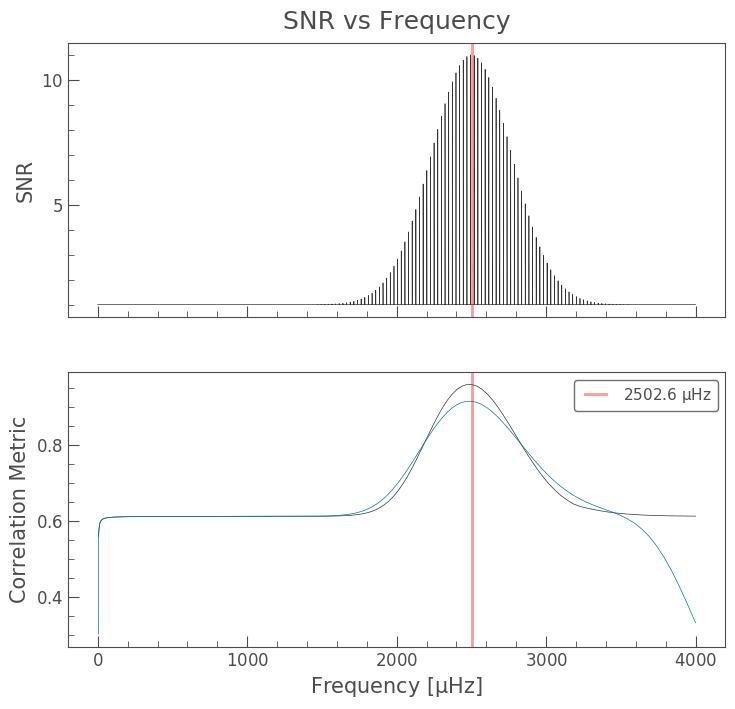

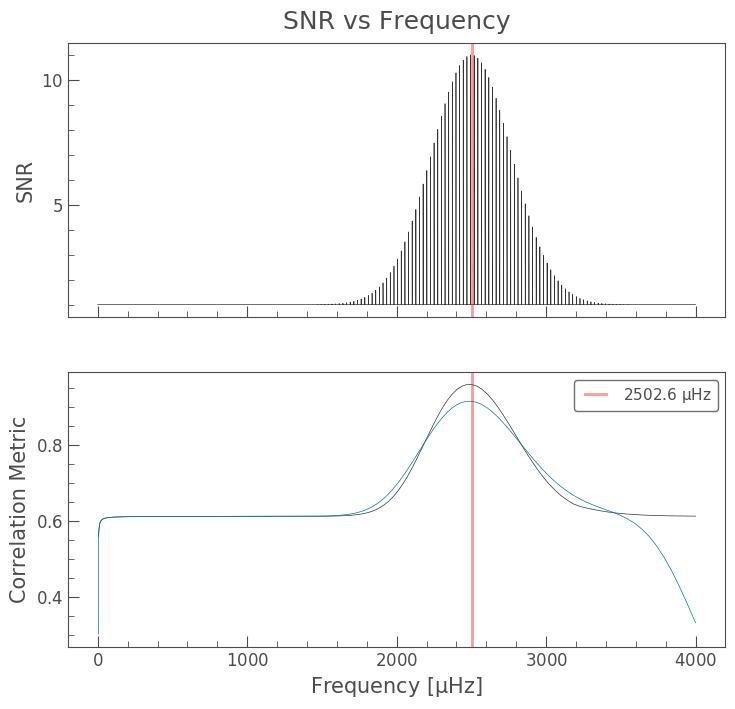

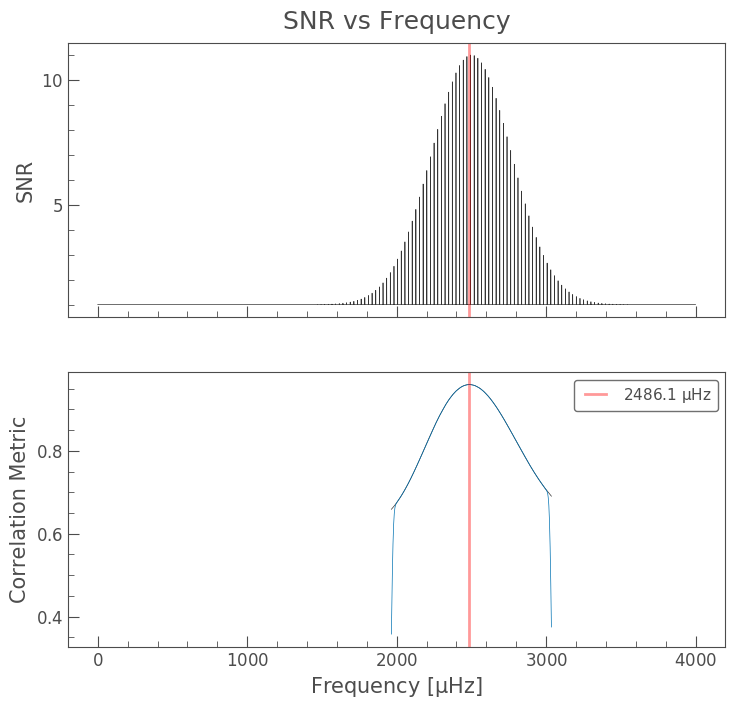

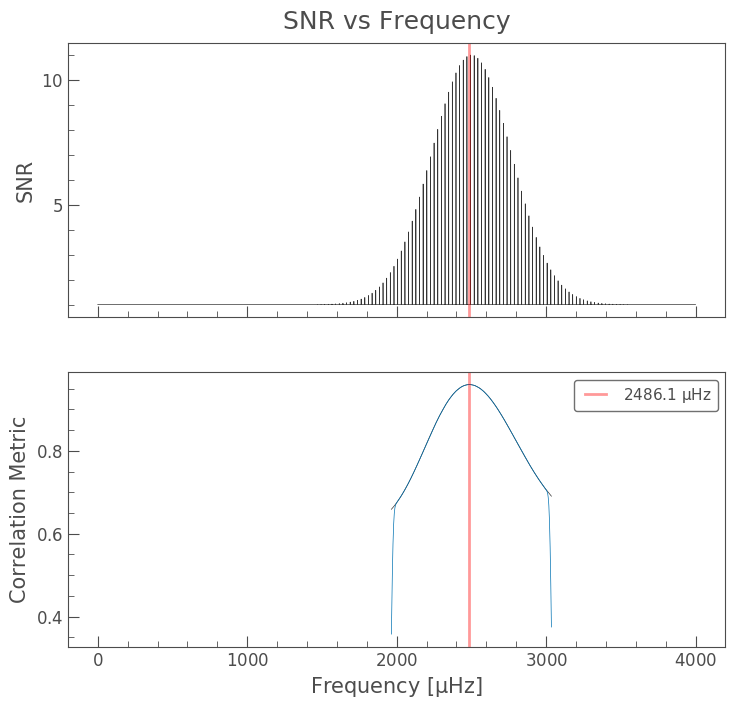

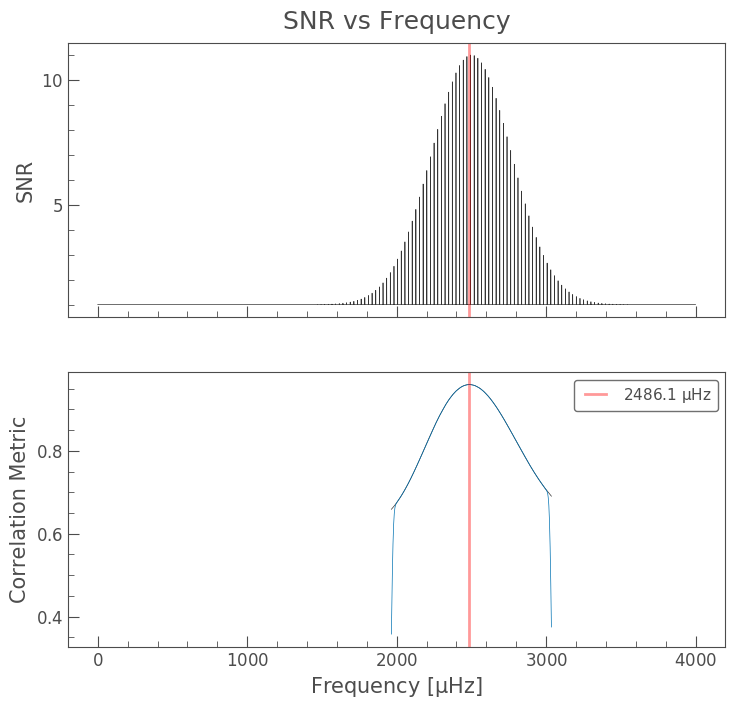

In [5]:
    """Test if we can estimate numax using the diagnostics function, and that
    it returns a correct metric when requested
    """
    f, p, true_numax, _ = generate_test_spectrum()
    std = 0.25*true_numax/2.335  # The standard deviation of the mode envelope
    snr = SNRPeriodogram(f*u.microhertz, u.Quantity(p, None))
    numaxs = np.linspace(true_numax-2*std, true_numax+2*std, 500)

    numax, _ = snr.plot_numax_diagnostics()
    #Note: checks on the `numaxs` kwarg in `estimate_numax_kwargs` also apply
    #to this function, no need to check them twice.

    #Assert recovers numax within 10%
    assert(np.isclose(true_numax, numax.value, atol=.1*true_numax))
    #Assert numax has unit equal to input frequency unit
    assert(numax.unit == u.microhertz)

    # Sanity check that plotting works under all conditions
    numax, ax = snr.plot_numax_diagnostics()
    numax, ax = snr.plot_numax_diagnostics(numaxs=numaxs)
    numax, ax = snr.plot_numax_diagnostics(numaxs=daynumaxs)

    #Check metric of appropriate length is returned
    _, _, metric = snr.plot_numax_diagnostics(numaxs=numaxs,return_metric=True)
    assert(len(metric) == len(numaxs))


test estimate dnu basics

In [6]:
    """Test if we can estimate a dnu
    """
    f, p, _, true_dnu = generate_test_spectrum()
    snr = SNRPeriodogram(f*u.microhertz, u.Quantity(p, None))
    dnu = snr.estimate_dnu()

    #Assert recovers dnu within 25%
    assert(np.isclose(true_dnu, dnu.value, atol=.25*true_dnu))
    #Assert dnu has unit equal to input frequency unit
    assert(dnu.unit == u.microhertz)
    #Assert dnu estimator works when input frequency is not in microhertz
    fday = u.Quantity(f*u.microhertz, 1/u.day)
    daysnr = SNRPeriodogram(fday, u.Quantity(p, None))
    dnu = daysnr.estimate_dnu()
    dnuday = u.Quantity(true_dnu*u.microhertz, 1/u.day)
    assert(np.isclose(dnuday.value, dnu.value, atol=.25*dnuday.value))

test estimate dnu kwargs

In [7]:
"""Test if we can estimate a dnu using its various keyword arguments
"""
f, p, _, true_dnu = generate_test_spectrum()
snr = SNRPeriodogram(f*u.microhertz, u.Quantity(p, None))

# Assert custom numax works
numax = snr.estimate_numax()
dnu = snr.estimate_dnu(numax)
assert(np.isclose(dnu.value, true_dnu, atol=.25*true_dnu))

# Assert you can't pass custom numax outside of appropriate range
with pytest.raises(ValueError) as err:
    dnu = snr.estimate_dnu(numax= -5.)
with pytest.raises(ValueError) as err:
    dnu = snr.estimate_dnu(numax=5000)

# Assert it doesn't matter what units of frequency numax is passed in as
daynumax = u.Quantity(numax.value*u.microhertz, 1/u.day)
dnu = snr.estimate_dnu(numax=daynumax)
assert(np.isclose(dnu.value, true_dnu, atol=.25*true_dnu))
assert(dnu.unit == u.microhertz)

test plot dnu diagnostics

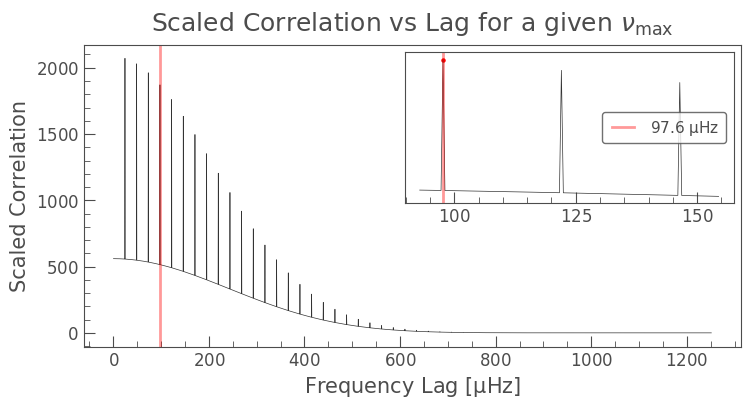

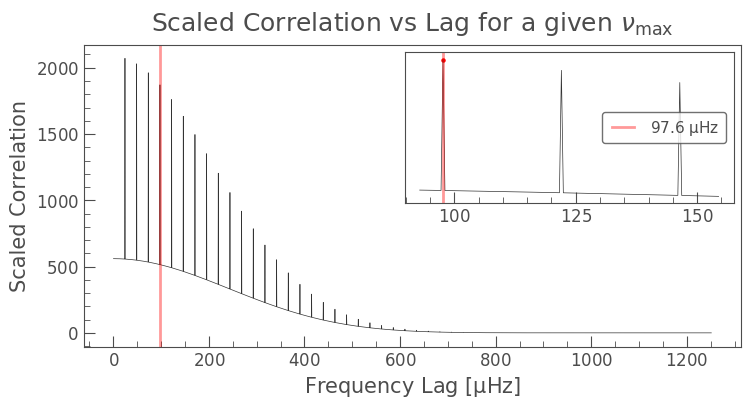

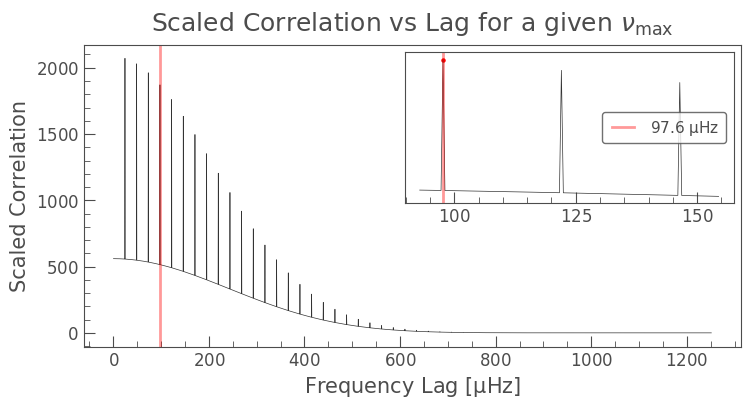

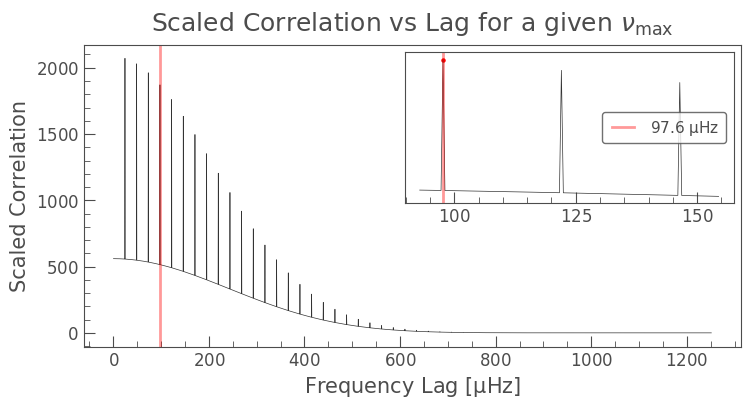

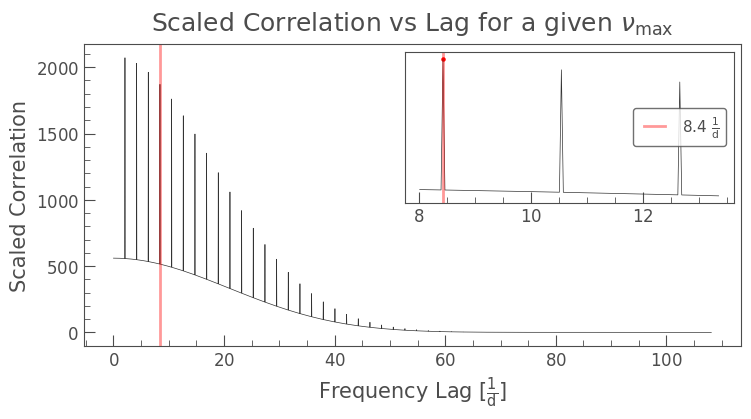

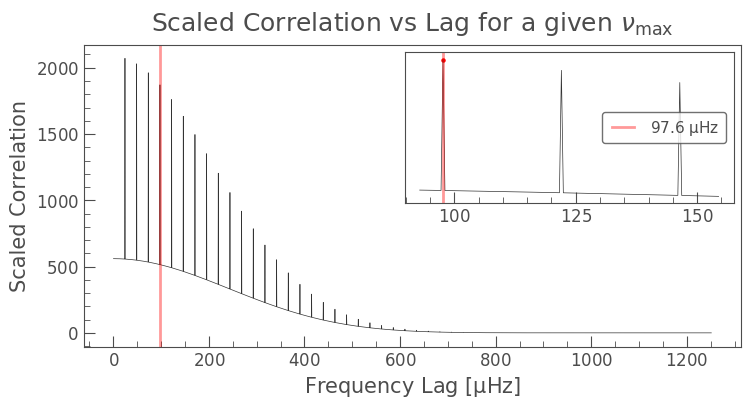

In [8]:
    """Test if we can estimate numax using the diagnostics function, and that
    it returns a correct metric when requested
    """
    f, p, _, true_dnu = generate_test_spectrum()
    snr = SNRPeriodogram(f*u.microhertz, u.Quantity(p, None))

    # Assert custom numax works
    dnu, _ = snr.plot_dnu_diagnostics()
    assert(np.isclose(dnu.value, true_dnu, atol=.25*true_dnu))
    assert(dnu.unit == u.microhertz)

    #Note: checks on the `numax` kwarg in `estimate_dnu_kwargs` also apply
    #to this function, no need to check them twice.

    # Sanity check that plotting works under all conditions
    dnu, ax = snr.plot_dnu_diagnostics()
    dnu, ax = snr.plot_dnu_diagnostics(numax=numax)
    dnu, ax = snr.plot_dnu_diagnostics(numax=daynumax)

    #Check it plots when frequency is in days
    fday = u.Quantity(f*u.microhertz, 1/u.day)
    daysnr = SNRPeriodogram(fday, u.Quantity(p, None))
    dnu, ax = daysnr.plot_dnu_diagnostics(numax=daynumax)

    #Check metric of appropriate length is returned
    _, _, metric = snr.plot_dnu_diagnostics(numax=numax, return_metric=True)
    assert(len(metric) == len(snr._autocorrelate(numax.value)))